# MODIS albedo reprocessing comparisons
*J. Michelle Hu  
University of Utah  
September 2024*  
---

How does the original model handle no snow albedo?  

Fill in minimum value when albedo is nan

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyproj
import geopandas as gpd
import xarray as xr
# import hvplot.xarray

from s3fs import S3FileSystem, S3Map

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/studio/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%reload_ext autoreload
%autoreload 2

### Env setup

In [3]:
from pathlib import PurePath
# Locate pyproj_datadir for studio env
# From https://stackoverflow.com/questions/69630630/on-fresh-conda-installation-of-pyproj-pyproj-unable-to-set-database-path-pypr
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem

# /uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj
pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


### Directories and global variables

In [4]:
old_MODIS_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/'
new_MODIS_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed_nans/'

# Plot the differences between MODIS reprocessing Jan 20 of each water year
albedo_fns = [h.fn_list(modis_dir, f'*/*0120_*albedo.tif') for modis_dir in [old_MODIS_dir, new_MODIS_dir]]
albedo_fns

[['/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2019/westernUS_Terra_20190120_albedo.tif',
  '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2020/westernUS_Terra_20200120_albedo.tif',
  '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2021/westernUS_Terra_20210120_albedo.tif',
  '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2022/westernUS_Terra_20220120_albedo.tif',
  '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2022/westernUS_Terra_20220120_reprocess_albedo.tif',
  '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2023/westernUS_Terra_20230120_albedo.tif',
  '/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2023/westernUS_Terra_20230120_reprocess_albedo.tif'],
 ['/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_

20190120_albedo
20200120_albedo
20210120_albedo
20220120_albedo
20220120_reprocess_albedo
20230120_albedo
20230120_reprocess_albedo
CPU times: user 38.9 s, sys: 28.3 s, total: 1min 7s
Wall time: 1min 10s


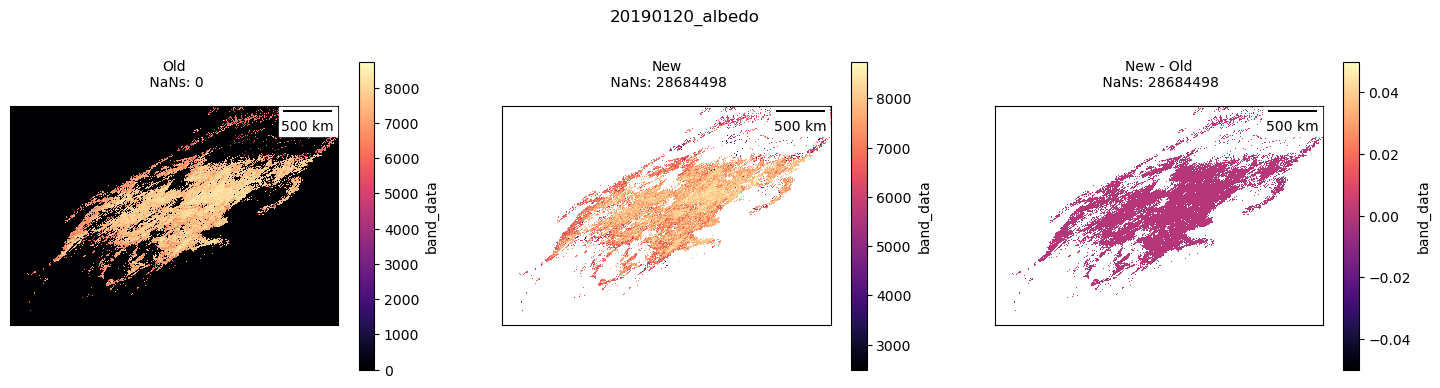

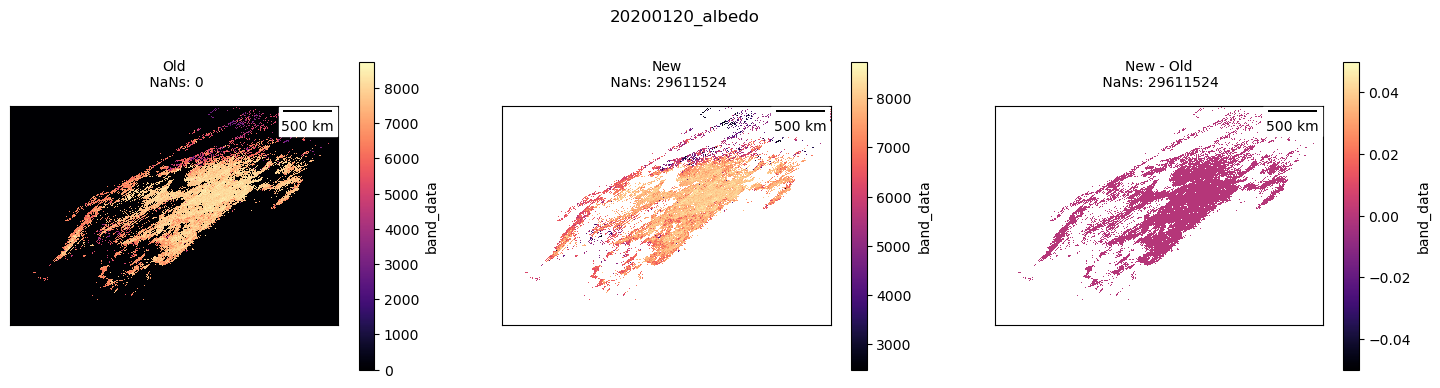

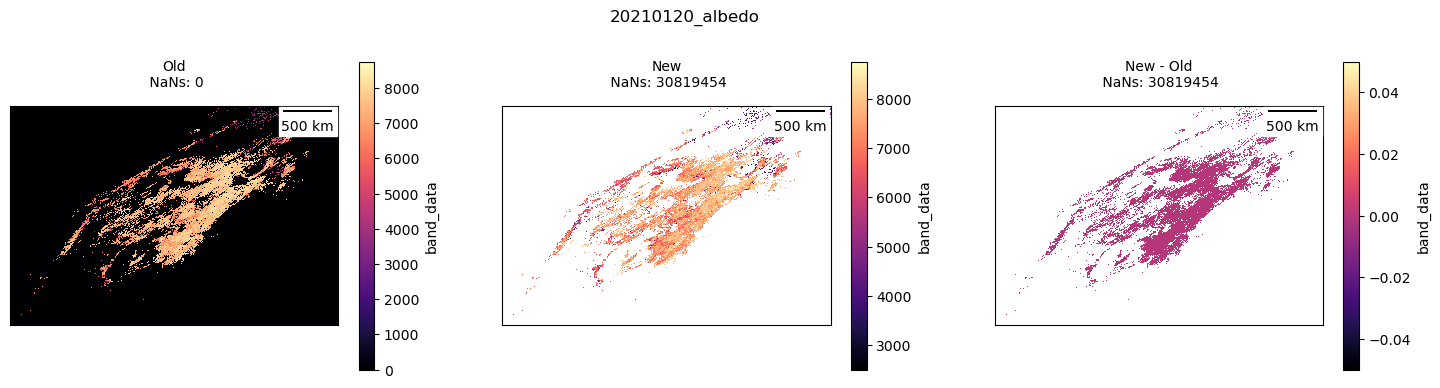

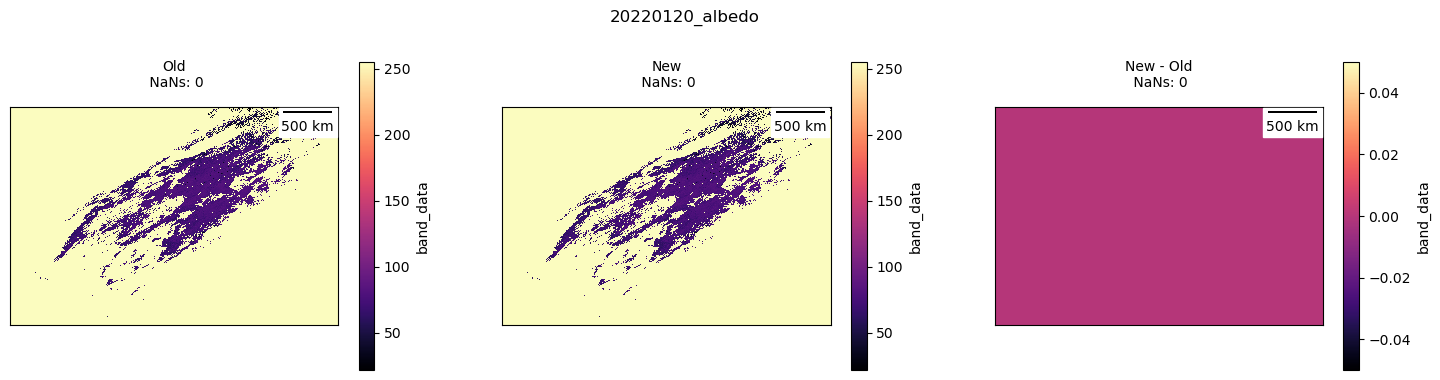

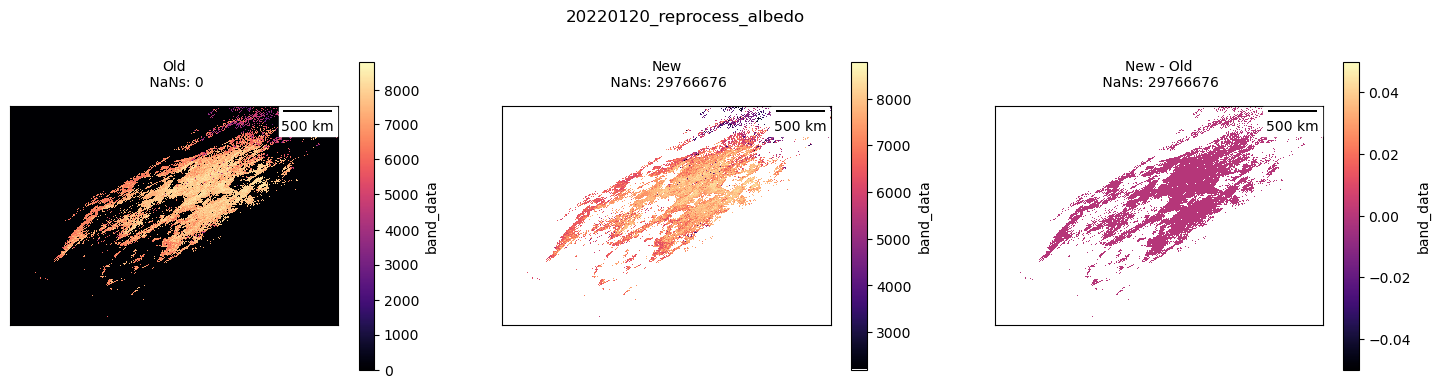

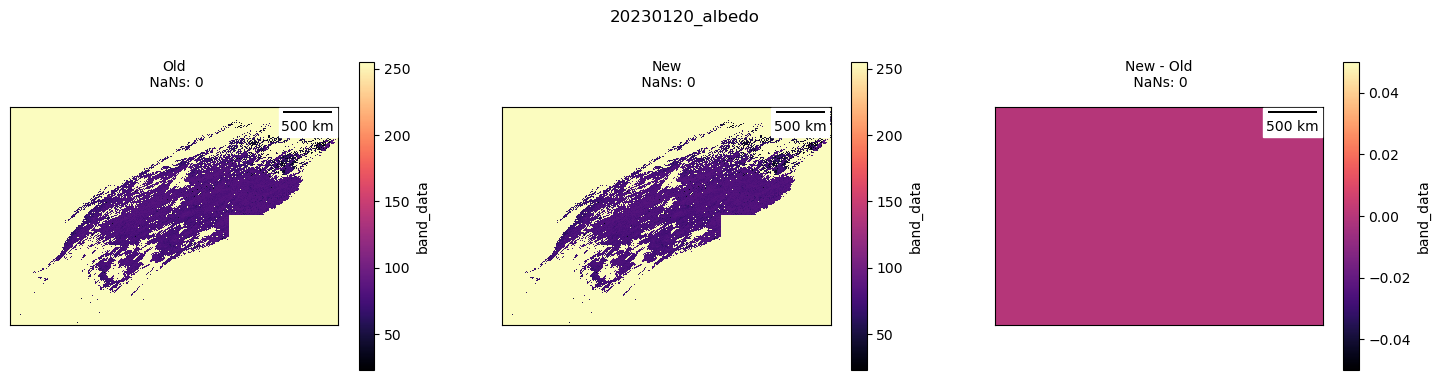

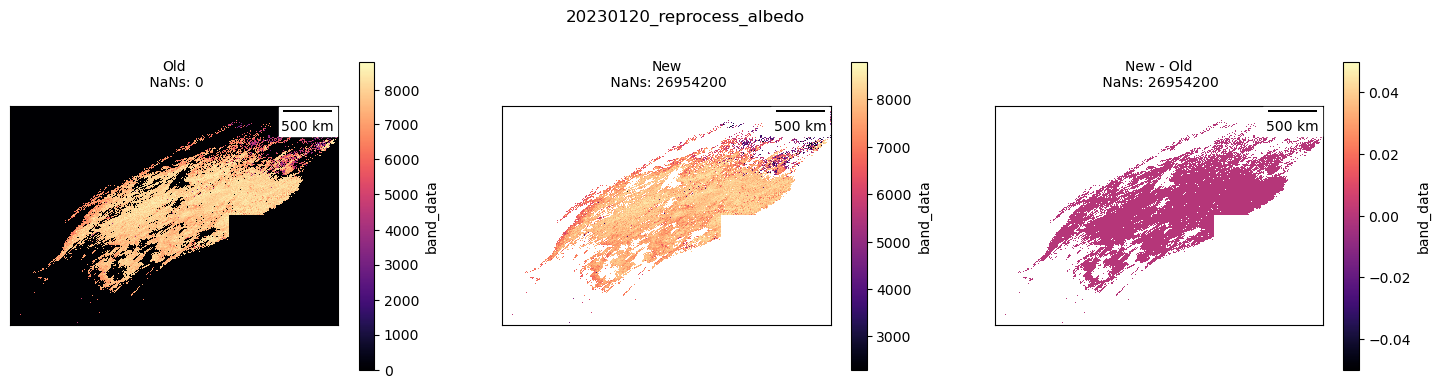

In [5]:
%%time
figsize = (18, 4)
for old_fn, new_fn in zip(albedo_fns[0], albedo_fns[1]):
    title = PurePath(old_fn).stem.split('Terra_')[1]
    print(title)
    old = np.squeeze(xr.open_dataset(old_fn))
    new = np.squeeze(xr.open_dataset(new_fn))
    diff = new - old

    axtitles = ['Old', 'New', 'New - Old']
    arrs = [old['band_data'], new['band_data'], diff['band_data']]
    nancounts = [int(np.isnan(arr).sum()) for arr in arrs]
    # cbars = [False, False, True]
        
    # plot individual and plot diff
    fig, axa = plt.subplots(1, 3, figsize=figsize)
    for jdx, ax in enumerate(axa.flatten()):
        h.plot_one(arrs[jdx], specify_ax=(fig, ax), title=f'{axtitles[jdx]}\n NaNs: {nancounts[jdx]}', 
                   # cbaron=cbars[jdx],
                   turnoffaxes=True, turnofflabels=True
                  )
    plt.suptitle(title, y=1.01)

In [6]:
# Make a vid of all the WY 2023 original tifs to see if they are all missing a tile
wy2023_fns = h.fn_list(old_MODIS_dir, f'*2023/*albedo.tif')
wy2023_fns = [f for f in wy2023_fns if 'reprocess' in PurePath(f).stem]
len(wy2023_fns)

365

In [7]:
import matplotlib.animation as animation

In [8]:
%%time
arrs = [np.squeeze(xr.open_dataset(arr_fn, chunks='auto'))['band_data'] for arr_fn in wy2023_fns]

CPU times: user 1min 22s, sys: 3.78 s, total: 1min 26s
Wall time: 1min 41s


In [9]:
outdir = './pngs'

In [ ]:
%%time
# Make frames and save as pngs
for jdx, arr in enumerate(arrs):
    if jdx > 191:
        h.plot_one(arr, title=f'{PurePath(wy2023_fns[jdx]).stem}', figsize=(6, 4))
        plt.savefig(f'{outdir}/{PurePath(wy2023_fns[jdx]).stem}.png')
        plt.close()

In [ ]:
%%time
# Compress all the arrays into a single dataarray
arrs = xr.concat(arrs, dim='time')

In [ ]:
titles = [PurePath(f).stem.split('Terra_')[1] for f in wy2023_fns]

In [ ]:
%%time
# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(6, 4))

# Plot the initial frame. 
cax = arrs[0,:,:].plot.imshow(
        add_colorbar=True,
        cmap='magma',
        vmin=0, vmax=10000,
        cbar_kwargs={
            'extend':'neither'
        }
)
ax.set_title('');

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(arrs[frame,:,:].values)
    ax.set_title(titles[frame])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=len(titles),       # Could also be iterable or list
    interval=200     # ms between frames
)

In [ ]:
%%time
writergif = animation.PillowWriter(fps=30)
ani.save('movie.gif', writer=writergif)